In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

after i did the measurements (600000 times in total), i collect all the inputs into one big data set so it'll be easier to manipulate.

the inputs are:

>$1111111111\\1111000000\\1000111000\\0100100011\\0010010101\\0001001110$


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
raw_data_input_table = np.load('/content/drive/My Drive/Shared drive/all results.npy', allow_pickle=True)
states_names = ['1111111111','1111000000','1000111000','0100100011','0010010101','0001001110']

In [ ]:
result_table = []
for i in range(6):
      results = pd.DataFrame({"q0": raw_data_input_table[i][:,0], "q1": raw_data_input_table[i][:,1], "q2": raw_data_input_table[i][:,2],
                        "q3": raw_data_input_table[i][:,3], "q4": raw_data_input_table[i][:,4], "q5": raw_data_input_table[i][:,5],
                        "q6": raw_data_input_table[i][:,6], "q7": raw_data_input_table[i][:,7], "q8": raw_data_input_table[i][:,8], "q9": raw_data_input_table[i][:,9]})
      result_table.append(results)

here i've done an histogram to each input, so we can see how many have been 1 or zeros in total - and count them as well

0100100011


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9
0,581539,25596,551538,589666,80234,581890,595514,565655,35574,97987
1,18461,574404,48462,10334,519766,18110,4486,34345,564426,502013


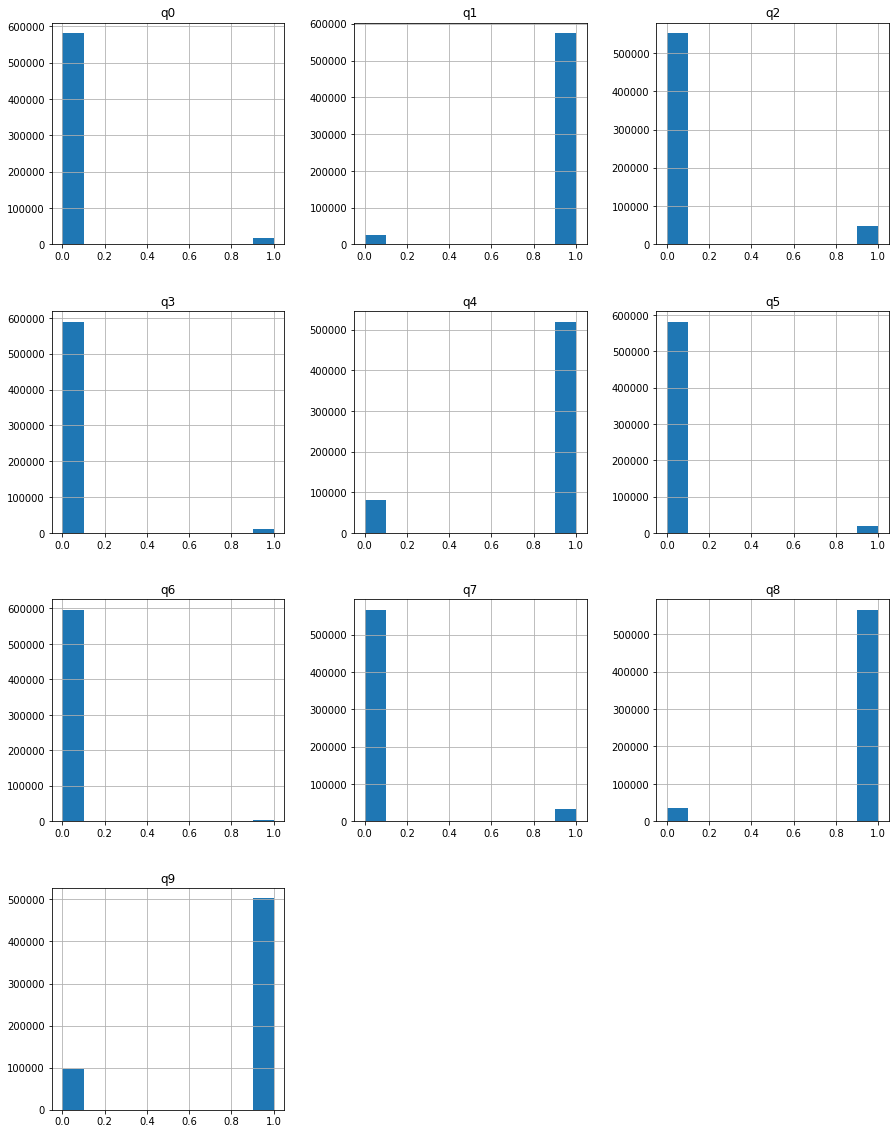

In [ ]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
print(states_names[3])
result_table[3].hist(ax = ax)
result_table[3].apply(pd.value_counts)

now i did a peasron correlation:
$CORR=\frac{<q_{i}q_{j}>-<q_{i}><q_{j}>}{\sqrt{(<q_{i}^{2}>-<q_{i}>^{2})(<q_{j}^{2}>-<q_{j}>^{2})}}$

in other words, it's the covariance devided by the multiplication of standart deviation

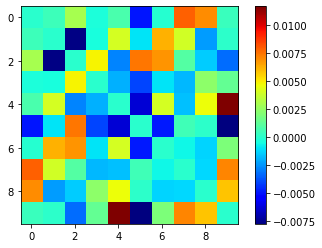

In [ ]:
plt.figure()
res=result_table[3].corr()
mydiag=np.diag(np.diag(res))
plt.imshow(res-mydiag, cmap='jet')
plt.colorbar()
plt.show()

now what i'm gonna to do is calculation $\varepsilon_{j}$ and $\eta_{j}$ for the A tensor mitigitating error, and calculating the A tensor at the end for all the possible inputs for n qubits

$A=\begin{pmatrix}
1-\varepsilon_{0} & \eta_{0} \\
\varepsilon_{0}  & 1-\eta_{0} \\ 
\end{pmatrix}\otimes...\otimes\begin{pmatrix}
1-\varepsilon_{n} & \eta_{n} \\
\varepsilon_{n}  & 1-\eta_{n} \\ 
\end{pmatrix}$

in order to distinguish which error are we computing, i did a quantum simulation Rigetti where the qubits get the pure string result.
this way i can compute the A tensor

In [ ]:
simulation_data_input_table = np.load('/content/drive/My Drive/Shared drive/all simulation.npy', allow_pickle=True)


In [ ]:
np.unique(np.array(simulation_data_input_table), axis=1)

array([[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],

       [[1, 1, 1, 1, 0, 0, 0, 0, 0, 0]],

       [[1, 0, 0, 0, 1, 1, 1, 0, 0, 0]],

       [[0, 1, 0, 0, 1, 0, 0, 0, 1, 1]],

       [[0, 0, 1, 0, 0, 1, 0, 1, 0, 1]],

       [[0, 0, 0, 1, 0, 0, 1, 1, 1, 0]]])

In [ ]:
measurements_in_total=np.array(simulation_data_input_table).reshape([3600000,10])
Error_eps = np.zeros([10,1])
Error_eta = np.zeros([10,1])
for i in range(6):
  for column in result_table[i].columns:
    if simulation_data_input_table[i][0,result_table[i].columns.get_loc(column)] == 0:
      Error_eps[result_table[i].columns.get_loc(column)] = Error_eps[result_table[i].columns.get_loc(column)] + len(result_table[i][result_table[i][column] == 1][column])/len(measurements_in_total[:,i][measurements_in_total[:,i]==0])
    else:
      Error_eta[result_table[i].columns.get_loc(column)] = Error_eta[result_table[i].columns.get_loc(column)] + len(result_table[i][result_table[i][column] == 0][column])/len(measurements_in_total[:,i][measurements_in_total[:,i]==1])

what i did wrong is instead of looking at the total measurements(which is 6 multiplied by 600000), i look at each input individually...
i need to devide by the amount of the total measurements, where i expect it to be 0/1.

In [ ]:
print(Error_eps.T,
      Error_eta.T)

[[0.03089389 0.05996056 0.05822167 0.01503111 0.02957778 0.03894833
  0.00936833 0.038275   0.02260556 0.05321944]] [[0.03201889 0.14017167 0.04363722 0.123465   0.10762222 0.06854167
  0.24804556 0.07527889 0.08958833 0.16576667]]


in order to see if $\varepsilon_{j}$ and $\eta_{j}$ are legitimate, i'll calculate the average of each qubit (all inputs) and see if they correspond to the error.

In [ ]:
average_qbits = np.zeros([10,1])
RME_before = np.zeros([6])
RME = np.zeros([10,1])
for i in range(6):
  for column in result_table[i].columns:
    average_qbits[result_table[i].columns.get_loc(column)] = result_table[i][column].mean()
    RME[result_table[i].columns.get_loc(column)] = np.sqrt((simulation_data_input_table[i][0][result_table[i].columns.get_loc(column)]-average_qbits[result_table[i].columns.get_loc(column)])**2)
  RME_before[i] = np.mean(RME)
  print(simulation_data_input_table[i][0],
  average_qbits, np.mean(RME))

[1 1 1 1 1 1 1 1 1 1] [[0.971435  ]
 [0.76565333]
 [0.95217   ]
 [0.85104333]
 [0.96102833]
 [0.976995  ]
 [0.58131667]
 [0.87336667]
 [0.95673167]
 [0.83561   ]] 0.127465
[1 1 1 1 0 0 0 0 0 0] [[0.96868167]
 [0.85649167]
 [0.95100333]
 [0.81701   ]
 [0.03295667]
 [0.08018   ]
 [0.01521833]
 [0.02859167]
 [0.00599167]
 [0.05185167]] 0.06216033333333333
[1 0 0 0 1 1 1 0 0 0] [[0.96382667]
 [0.03227833]
 [0.07848667]
 [0.01463667]
 [0.84982833]
 [0.952575  ]
 [0.808225  ]
 [0.02899167]
 [0.00601667]
 [0.05093167]] 0.06368866666666667
[0 1 0 0 1 0 0 0 1 1] [[0.03076833]
 [0.95734   ]
 [0.08077   ]
 [0.01722333]
 [0.86627667]
 [0.03018333]
 [0.00747667]
 [0.05724167]
 [0.94071   ]
 [0.83668833]] 0.062264833333333325
[0 0 1 0 0 1 0 1 0 1] [[0.03108   ]
 [0.07236167]
 [0.965915  ]
 [0.01323333]
 [0.02763333]
 [0.864805  ]
 [0.00541   ]
 [0.95067   ]
 [0.05580833]
 [0.83040167]] 0.05937349999999999
[0 0 0 1 0 0 1 1 1 0] [[0.03083333]
 [0.07524167]
 [0.01540833]
 [0.96155167]
 [0.02814333]
 [0

In [ ]:
ten_qubits = []
for i in range(10):
    qbit = np.eye(2) + np.reshape(np.array([-Error_eps[i],Error_eta[i],Error_eps[i],-Error_eta[i]]), (2,2))
    ten_qubits.append(qbit)
ten_qubits = np.array(ten_qubits)
ten_qubits

array([[[0.96910611, 0.03201889],
        [0.03089389, 0.96798111]],

       [[0.94003944, 0.14017167],
        [0.05996056, 0.85982833]],

       [[0.94177833, 0.04363722],
        [0.05822167, 0.95636278]],

       [[0.98496889, 0.123465  ],
        [0.01503111, 0.876535  ]],

       [[0.97042222, 0.10762222],
        [0.02957778, 0.89237778]],

       [[0.96105167, 0.06854167],
        [0.03894833, 0.93145833]],

       [[0.99063167, 0.24804556],
        [0.00936833, 0.75195444]],

       [[0.961725  , 0.07527889],
        [0.038275  , 0.92472111]],

       [[0.97739444, 0.08958833],
        [0.02260556, 0.91041167]],

       [[0.94678056, 0.16576667],
        [0.05321944, 0.83423333]]])

______________________________________________
a tensor product is computed by:
$A\otimes B=\begin{pmatrix}
a_{00} & a_{01} \\
a_{10} & a_{11}
\end{pmatrix}\otimes B = \begin{pmatrix}
a_{00}B & a_{01}B \\
a_{10}B & a_{11}B
\end{pmatrix}$

so the tensor product is actually gets increased by $2^{2\cdot 2}=16$

if we do $A \otimes B \otimes C$ then the dimension will be $2^{2\cdot3}=2^{6}=64$ , and for N matrices the dimension will be $2^{2\cdot N}$

so if we are dealing with 10 qbits, then it'll be 1,048,576 elements in A, as the number of rows and columns are 1024 - very huge matrix.

\
the next code i did the A tensor by doing the following:

$(A_{0} \otimes (A_{1} \otimes( A_{2} \otimes( A_{3} \otimes( A_{4} \otimes( A_{5} \otimes (A_{6} \otimes (A_{7} \otimes( A_{8} \otimes A_{9})))))))))$




In [ ]:
A_tensor = np.array([])
for i in range(9,0,-1):
  print(i)
  if i == 9:
    A_tensor = np.kron(ten_qubits[i-1],ten_qubits[i])
  else:
    A_tensor = np.kron(ten_qubits[i-1],A_tensor)

9
8
7
6
5
4
3
2
1


In [ ]:
A_tensor.shape

(1024, 1024)

In [ ]:
np.linalg.inv(A_tensor)

array([[ 1.50248825e+00, -2.98552527e-01, -1.47851157e-01, ...,
        -2.46583734e-09, -1.22114828e-09,  2.42648755e-10],
       [-9.58503898e-02,  1.70519039e+00,  9.43208110e-03, ...,
         1.40836930e-08,  7.79024651e-11, -1.38589457e-09],
       [-3.73068393e-02,  7.41307035e-03,  1.61303257e+00, ...,
         6.12268330e-11,  1.33225332e-08, -2.64725927e-09],
       ...,
       [-1.59167627e-13,  2.83161193e-12,  1.56627632e-14, ...,
         3.17502414e+00,  1.75623117e-02, -3.12435716e-01],
       [-6.19511415e-14,  1.23100262e-14,  2.67857613e-12, ...,
         1.38029615e-02,  3.00342846e+00, -5.96797448e-01],
       [ 3.95213809e-15, -7.03090296e-14, -1.70878252e-13, ...,
        -7.88359675e-02, -1.91602023e-01,  3.40862389e+00]])

In [ ]:
np.dot(np.linalg.inv(A_tensor),A_tensor)

array([[ 1.00000000e+00,  8.41516279e-17, -9.15667847e-18, ...,
         8.78875307e-23,  3.41390056e-23,  7.57817510e-24],
       [-3.11898795e-18,  1.00000000e+00,  8.40926700e-19, ...,
        -7.06466986e-23, -3.54430242e-25, -8.51672468e-24],
       [ 3.38644260e-18, -6.27922663e-19,  1.00000000e+00, ...,
        -1.10205636e-24, -9.41935863e-23, -1.11730551e-23],
       ...,
       [ 2.32551878e-28,  3.29466956e-27,  8.99660215e-29, ...,
         1.00000000e+00, -1.53243939e-18,  2.76585394e-17],
       [ 7.45394281e-28,  3.14424029e-29,  1.30624608e-26, ...,
         4.13509214e-19,  1.00000000e+00,  2.66240698e-18],
       [ 3.86240017e-29,  5.79799017e-28, -7.85795519e-28, ...,
        -2.33456785e-18,  1.10234052e-17,  1.00000000e+00]])

in order to make a reversable of this tensor, there's a nice property of the kronecker product:
$(A \otimes B)^{-1} = A^{-1} \otimes B^{-1}$

for 3 matrices:

$(A \otimes B \otimes C)^{-1} = A^{-1} \otimes B^{-1} \otimes C^{-1}$ 
and so on...

so what am i going to do is first reverse each matrix individually, and then i'll do a product.
______________________________________________


In [ ]:
ten_qubits_reverse = np.array(ten_qubits)
for i in range(10):
  ten_qubits_reverse[i] = np.linalg.inv(ten_qubits[i])
ten_qubits_reverse
with open('A tensor.npy', 'wb') as f:
    np.save(f, ten_qubits_reverse)
ten_qubits_reverse*ten_qubits

array([[[ 1.00105560e+00, -1.09403823e-03],
        [-1.01850964e-03,  1.00105560e+00]],

       [[ 1.01050770e+00, -2.45641801e-02],
        [-4.49482817e-03,  1.01050770e+00]],

       [[ 1.00282877e+00, -2.12016479e-03],
        [-3.77419809e-03,  1.00282877e+00]],

       [[ 1.00215416e+00, -1.76941816e-02],
        [-2.62255695e-04,  1.00215416e+00]],

       [[ 1.00368941e+00, -1.34243657e-02],
        [-1.01396029e-03,  1.00368941e+00]],

       [[ 1.00299110e+00, -5.26376183e-03],
        [-1.69967022e-03,  1.00299110e+00]],

       [[ 1.00312930e+00, -8.28544955e-02],
        [-1.18189215e-04,  1.00312930e+00]],

       [[ 1.00325039e+00, -6.39284333e-03],
        [-1.65263924e-03,  1.00325039e+00]],

       [[ 1.00228112e+00, -9.04034042e-03],
        [-5.75588674e-04,  1.00228112e+00]],

       [[ 1.01129559e+00, -3.51832255e-02],
        [-3.62645186e-03,  1.01129559e+00]]])

______________________________________________

is it ok that it's almost an I matrix?

In [ ]:
A_tensor_inverse = np.array([])
for i in range(9,0,-1):
  print(i)
  if i == 9:
    A_tensor_inverse = np.kron(ten_qubits_reverse[i-1],ten_qubits_reverse[i])
  else:
    A_tensor_inverse = np.kron(ten_qubits_reverse[i-1],A_tensor_inverse)

9
8
7
6
5
4
3
2
1


In [ ]:
A_tensor_inverse.shape

(1024, 1024)

In [ ]:
np.dot(A_tensor,A_tensor_inverse)

array([[ 1.00000000e+00, -1.24052580e-16, -9.50185904e-18, ...,
         3.53546574e-24,  1.08122660e-24, -4.90637009e-25],
       [-1.69343988e-18,  1.00000000e+00, -7.78103637e-19, ...,
        -2.09104252e-24, -8.86246732e-26,  6.25734527e-25],
       [ 1.08258735e-17, -8.14120440e-19,  1.00000000e+00, ...,
         5.02021087e-26, -1.39924023e-23,  1.61867447e-24],
       ...,
       [ 1.69281954e-28,  1.44910792e-28, -1.21535440e-30, ...,
         1.00000000e+00,  4.57322627e-20, -9.16215211e-18],
       [ 1.26797489e-30, -7.43166816e-30, -1.03043883e-28, ...,
        -9.97347248e-19,  1.00000000e+00,  1.85725022e-18],
       [ 1.77871506e-30,  6.01246236e-29,  1.32636759e-29, ...,
         2.71163687e-18,  8.84522000e-18,  1.00000000e+00]])

______________________________________________


In [ ]:
RME_after = np.zeros([6])
RME = np.zeros([10,1])
average_qbits = np.zeros([10,1])
Z=np.array([[0,0],[0,1]])
for i in range(6):
  for column in result_table[i].columns:
    ii = result_table[i].columns.get_loc(column)
    Sij=np.array([result_table[i][column][result_table[i][column] == 0 ].count(),result_table[i][column][result_table[i][column] == 1 ].count()])
    average_qbits[ii] = np.dot(np.array([1,1]),np.dot(Z,np.dot(ten_qubits_reverse[ii],Sij)))/600000
    RME[ii] = np.sqrt((simulation_data_input_table[i][0][ii]-average_qbits[ii])**2)
  RME_after[i] = np.mean(RME)
  print(simulation_data_input_table[i][0],
  average_qbits, np.mean(RME))

[1 1 1 1 1 1 1 1 1 1] [[1.00368577]
 [0.88226179]
 [0.99533172]
 [0.97041027]
 [1.07956717]
 [1.0510209 ]
 [0.77021146]
 [0.94206704]
 [1.05217355]
 [1.00176267]] 0.06279277849064717
[1 1 1 1 0 0 0 0 0 0] [[ 1.00074759]
 [ 0.99582848]
 [ 0.99403274]
 [ 0.93090571]
 [ 0.00391619]
 [ 0.04619743]
 [ 0.00787787]
 [-0.01092377]
 [-0.01871342]
 [-0.00175128]] 0.016936063265875018
[1 0 0 0 1 1 1 0 0 0] [[ 9.95566641e-01]
 [-3.46084978e-02]
 [ 2.25632696e-02]
 [-4.57855675e-04]
 [ 9.50684464e-01]
 [ 1.02365987e+00]
 [ 1.07577647e+00]
 [-1.04725298e-02]
 [-1.86852610e-02]
 [-2.92924084e-03]] 0.024290188754497746
[0 1 0 0 1 0 0 0 1 1] [[-1.33984919e-04]
 [ 1.12190973e+00]
 [ 2.51055575e-02]
 [ 2.54464576e-03]
 [ 9.69748364e-01]
 [-9.82061826e-03]
 [-2.54740378e-03]
 [ 2.13962997e-02]
 [ 1.03412720e+00]
 [ 1.00314335e+00]] 0.02509804239407522
[0 0 1 0 0 1 0 1 0 1] [[ 1.98605964e-04]
 [ 1.55039513e-02]
 [ 1.01063555e+00]
 [-2.08679009e-03]
 [-2.25364447e-03]
 [ 9.25319231e-01]
 [-5.33047047e-03]
 

(0.0, 0.3)

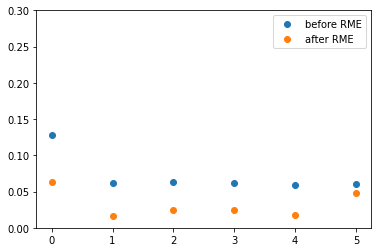

In [ ]:
RME_compare = pd.DataFrame(data={'before RME': RME_before.T.tolist(), 'after RME': RME_after.T.tolist()})
RME_compare.plot(style='o')
plt.ylim([0,0.3])

from here we can see that even if i take all the measurements and agitate them - it won't make an overfitting... is there something wrong with my calculation?

***all the calculations are right for the whole 600,000 measurements. now we can try to build a machine learning model of A reverse (by the article we can fix the average observation as well...) out of 300,000 of these "rows". this group will be called a train-group.***

In [ ]:
measurements_in_total_300000=np.array(simulation_data_input_table)[:,:300000].reshape([1800000,10])
Error_eps = np.zeros([10,1])
Error_eta = np.zeros([10,1])
for i in range(6):
  result_table_300000 = result_table[i][:300000]
  for column in result_table[i].columns:
    if simulation_data_input_table[i][0,result_table_300000.columns.get_loc(column)] == 0:
      Error_eps[result_table_300000.columns.get_loc(column)] = Error_eps[result_table_300000.columns.get_loc(column)] + len(result_table_300000[result_table_300000[column] == 1][column])/len(measurements_in_total_300000[:,i][measurements_in_total_300000[:,i]==0])
    else:
      Error_eta[result_table_300000.columns.get_loc(column)] = Error_eta[result_table_300000.columns.get_loc(column)] + len(result_table_300000[result_table_300000[column] == 0][column])/len(measurements_in_total_300000[:,i][measurements_in_total_300000[:,i]==1])

NameError: ignored

In [ ]:
print(Error_eps.T,
      Error_eta.T)

[[0.02966111 0.05987444 0.05747667 0.01520889 0.02983556 0.03847
  0.00933    0.03844333 0.02285111 0.05449889]] [[0.03123111 0.13644333 0.04358111 0.12392333 0.10167111 0.06471
  0.23148444 0.07520444 0.08874333 0.16519333]]


In [ ]:
ten_qubits = []
for i in range(10):
    qbit = np.eye(2) + np.reshape(np.array([-Error_eps[i],Error_eta[i],Error_eps[i],-Error_eta[i]]), (2,2))
    ten_qubits.append(qbit)
ten_qubits = np.array(ten_qubits)
ten_qubits

array([[[0.97033889, 0.03123111],
        [0.02966111, 0.96876889]],

       [[0.94012556, 0.13644333],
        [0.05987444, 0.86355667]],

       [[0.94252333, 0.04358111],
        [0.05747667, 0.95641889]],

       [[0.98479111, 0.12392333],
        [0.01520889, 0.87607667]],

       [[0.97016444, 0.10167111],
        [0.02983556, 0.89832889]],

       [[0.96153   , 0.06471   ],
        [0.03847   , 0.93529   ]],

       [[0.99067   , 0.23148444],
        [0.00933   , 0.76851556]],

       [[0.96155667, 0.07520444],
        [0.03844333, 0.92479556]],

       [[0.97714889, 0.08874333],
        [0.02285111, 0.91125667]],

       [[0.94550111, 0.16519333],
        [0.05449889, 0.83480667]]])

In [ ]:
ten_qubits_reverse = np.array(ten_qubits)
for i in range(10):
  ten_qubits_reverse[i] = np.linalg.inv(ten_qubits[i])
ten_qubits_reverse

array([[[ 1.03158435, -0.03325615],
        [-0.03158435,  1.03325615]],

       [[ 1.07450015, -0.16977274],
        [-0.07450015,  1.16977274]],

       [[ 1.06393811, -0.04848044],
        [-0.06393811,  1.04848044]],

       [[ 1.01766693, -0.14395165],
        [-0.01766693,  1.14395165]],

       [[ 1.03435323, -0.11706608],
        [-0.03435323,  1.11706608]],

       [[ 1.04289601, -0.07215495],
        [-0.04289601,  1.07215495]],

       [[ 1.01228949, -0.30491155],
        [-0.01228949,  1.30491155]],

       [[ 1.04337252, -0.08484713],
        [-0.04337252,  1.08484713]],

       [[ 1.02572149, -0.09989057],
        [-0.02572149,  1.09989057]],

       [[ 1.06984281, -0.21170279],
        [-0.06984281,  1.21170279]]])

In [ ]:
A_tensor = np.array([])
for i in range(9,0,-1):
  print(i)
  if i == 9:
    A_tensor = np.kron(ten_qubits[i-1],ten_qubits[i])
  else:
    A_tensor = np.kron(ten_qubits[i-1],A_tensor)

9
8
7
6
5
4
3
2
1


***our observation will be $\langle \sigma_{z} \rangle$. for our machine learning modelling will take the last 300,000 for each input - calculate $\langle \sigma_{z} \rangle$, and then will apply the A tensor i've described before (for first 300,000 measurements of each input) and see how it'll affect the observation.***

In [ ]:
RME_before = np.zeros([6])
RME_before_std = np.zeros([6])
RME = np.zeros([10,1])
average_qbits = np.zeros([10,1])
for i in range(6):
  result_table_300000_last = result_table[i][300000:]
  for column in result_table_300000_last.columns:
    average_qbits[result_table_300000_last.columns.get_loc(column)] = result_table_300000_last[column].mean()
    RME[result_table_300000_last.columns.get_loc(column)] = np.sqrt((simulation_data_input_table[i][0][result_table_300000_last.columns.get_loc(column)]-average_qbits[result_table_300000_last.columns.get_loc(column)])**2)
  RME_before[i] = np.mean(RME)
  RME_before_std[i] = np.std(RME)
  print(simulation_data_input_table[i][0],
  average_qbits, np.mean(RME))

[1 1 1 1 1 1 1 1 1 1] [[0.97136]
 [0.75888]
 [0.95234]
 [0.84628]
 [0.96098]
 [0.97658]
 [0.54298]
 [0.87246]
 [0.9569 ]
 [0.83712]] 0.13241199999999997
[1 1 1 1 0 0 0 0 0 0] [[0.96796]
 [0.8483 ]
 [0.95052]
 [0.81894]
 [0.03314]
 [0.08178]
 [0.01522]
 [0.02864]
 [0.00584]
 [0.04958]] 0.06284799999999999
[1 0 0 0 1 1 1 0 0 0] [[0.96226]
 [0.03218]
 [0.07914]
 [0.01442]
 [0.84472]
 [0.95262]
 [0.80954]
 [0.02898]
 [0.0058 ]
 [0.05056]] 0.064194
[0 1 0 0 1 0 0 0 1 1] [[0.032  ]
 [0.96112]
 [0.08264]
 [0.01748]
 [0.85358]
 [0.03002]
 [0.00772]
 [0.0567 ]
 [0.9395 ]
 [0.83488]] 0.063748
[0 0 1 0 0 1 0 1 0 1] [[0.0323 ]
 [0.07208]
 [0.96606]
 [0.01266]
 [0.02708]
 [0.85368]
 [0.00528]
 [0.9511 ]
 [0.05544]
 [0.82898]] 0.060501999999999986
[0 0 0 1 0 0 1 1 1 0] [[0.03208]
 [0.07588]
 [0.01512]
 [0.96576]
 [0.02774]
 [0.00648]
 [0.85366]
 [0.95038]
 [0.8323 ]
 [0.05568]] 0.061087999999999996


in the article we can "fix" the observation of tensor product by:

$\xi=M^{-1}\sum_{i=1}^{M}\prod_{j}^{n}\langle{e}|O_{j}\begin{bmatrix}
1-\varepsilon_{j} & \eta_{j} \\
\varepsilon_{j}  & 1-\eta_{j} \\ 
\end{bmatrix}^{-1}|s_{j}^{i}\rangle $

if we consider our observable as the average of each qubit as i did in [24] , we can see how by this calculation the average will be much farther - closer to 0 or 1.

to compare between the original observable and the fixed one, i calculated the mean-root-square-error before the fixation and after:

$\frac{\sum_{i=1}^{n}\sqrt{Y_{expected}^{2}-Y_{result}^{2}}}{n}$

_____________________________________________________________
now i'll write the things in more rigorous way. since the eigenvalues of Z are 1,-1 , i'll calculate the expectation value of these values , and the fixation will be not by the observable , but by the operator itself $O_{j}$ in the article... 

first i'm going to change the results from 0,1 to 1,-1 so it'll match the eigenvalues of $\sigma_{z}$

In [ ]:
def initialM(i):
  result_table_300000_last_x = result_table[i][300000:].copy()
  simulation_data_input_table_x = simulation_data_input_table[i].copy()
  simulation_data_input_table_x[simulation_data_input_table_x == 1] = -1
  simulation_data_input_table_x[simulation_data_input_table_x == 0] = 1
  result_table_300000_last_x[result_table_300000_last_x == 1] = -1
  result_table_300000_last_x[result_table_300000_last_x == 0] = 1
  return result_table_300000_last_x,simulation_data_input_table_x

after intial each input, first i see the $\sigma_{z}$ before mitigation, and after that i apply the equation and check the result

In [ ]:
RME_before = np.zeros([6])
RME_before_std = np.zeros([6])
RME = np.zeros([10,1])
average_qbits = np.zeros([10,1])
for i in range(6):
  result_table_300000_last_x,simulation_data_input_table_x = initialM(i)
  for column in result_table_300000_last_x.columns:
    ii=result_table_300000_last_x.columns.get_loc(column)
    average_qbits[ii] = result_table_300000_last_x[column].mean()
    RME[result_table_300000_last_x.columns.get_loc(column)] = np.abs(simulation_data_input_table_x[0][ii]-average_qbits[ii])
  RME_before[i] = np.mean(RME)
  print(simulation_data_input_table_x[0],
  average_qbits, np.mean(RME))

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1] [[-0.94272]
 [-0.51776]
 [-0.90468]
 [-0.69256]
 [-0.92196]
 [-0.95316]
 [-0.08596]
 [-0.74492]
 [-0.9138 ]
 [-0.67424]] 0.26482399999999995
[-1 -1 -1 -1  1  1  1  1  1  1] [[-0.93592]
 [-0.6966 ]
 [-0.90104]
 [-0.63788]
 [ 0.93372]
 [ 0.83644]
 [ 0.96956]
 [ 0.94272]
 [ 0.98832]
 [ 0.90084]] 0.12569600000000003
[-1  1  1  1 -1 -1 -1  1  1  1] [[-0.92452]
 [ 0.93564]
 [ 0.84172]
 [ 0.97116]
 [-0.68944]
 [-0.90524]
 [-0.61908]
 [ 0.94204]
 [ 0.9884 ]
 [ 0.89888]] 0.128388
[ 1 -1  1  1 -1  1  1  1 -1 -1] [[ 0.936  ]
 [-0.92224]
 [ 0.83472]
 [ 0.96504]
 [-0.70716]
 [ 0.93996]
 [ 0.98456]
 [ 0.8866 ]
 [-0.879  ]
 [-0.66976]] 0.127496
[ 1  1 -1  1  1 -1  1 -1  1 -1] [[ 0.9354 ]
 [ 0.85584]
 [-0.93212]
 [ 0.97468]
 [ 0.94584]
 [-0.70736]
 [ 0.98944]
 [-0.9022 ]
 [ 0.88912]
 [-0.65796]] 0.121004
[ 1  1  1 -1  1  1 -1 -1 -1  1] [[ 0.93584]
 [ 0.84824]
 [ 0.96976]
 [-0.93152]
 [ 0.94452]
 [ 0.98704]
 [-0.70732]
 [-0.90076]
 [-0.6646 ]
 [ 0.88864]] 0.1221760000000

In [ ]:
RME_after = np.zeros([6])
RME_after_std = np.zeros([6])
average_qbits = np.zeros([10,1])
for i in range(6):
  result_table_300000_last_x,simulation_data_input_table_x = initialM(i)
  for column in result_table_300000_last_x.columns:
    ii=result_table_300000_last_x.columns.get_loc(column)
    #if (column=='q6'):
    #  average_qbits[ii] = simulation_data_input_table_x[0][ii]
    #else :
    Z=np.array([[1,0],[0,-1]])
    Sij=np.array([result_table_300000_last_x[column][result_table_300000_last_x[column] == 1 ].count(),result_table_300000_last_x[column][result_table_300000_last_x[column] == -1 ].count()])
    average_qbits[ii] = np.dot(np.array([1,1]),np.dot(Z,np.dot(ten_qubits_reverse[ii],Sij)))/300000
    RME[ii] = np.sqrt((simulation_data_input_table_x[0][result_table_300000_last_x.columns.get_loc(column)]-average_qbits[result_table_300000_last_x.columns.get_loc(column)])**2)
  RME_after[i] = np.mean(RME)
  print(simulation_data_input_table_x[0],
  average_qbits, np.mean(RME))

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1] [[-1.00551824]
 [-0.73950732]
 [-0.99092514]
 [-0.93077528]
 [-1.1442754 ]
 [-1.09208091]
 [-0.40584867]
 [-0.88190799]
 [-1.10275337]
 [-1.00592928]] 0.14015928063804273
[-1 -1 -1 -1  1  1  1  1  1  1] [[-0.99827732]
 [-0.96203309]
 [-0.98687593]
 [-0.86725797]
 [ 0.9923904 ]
 [ 0.90341429]
 [ 0.98448337]
 [ 1.02212063]
 [ 1.03829582]
 [ 1.01260756]] 0.03782916373863691
[-1  1  1  1 -1 -1 -1  1  1  1] [[-0.98613814]
 [ 1.06891889]
 [ 0.95180261]
 [ 1.00183278]
 [-0.87654738]
 [-1.03864767]
 [-1.10807488]
 [ 1.02135344]
 [ 1.03838587]
 [ 1.01009573]] 0.04728211224741078
[ 1 -1  1  1 -1  1  1  1 -1 -1] [[ 0.99501891]
 [-1.24279082]
 [ 0.94401568]
 [ 0.99472367]
 [-0.89695053]
 [ 1.01884436]
 [ 1.00424139]
 [ 0.95880494]
 [-1.06358207]
 [-1.00018796]] 0.05401328672458845
[ 1  1 -1  1  1 -1  1 -1  1 -1] [[ 0.99438001]
 [ 0.96962592]
 [-1.0214499 ]
 [ 1.00592167]
 [ 1.0063456 ]
 [-0.81800138]
 [ 1.01066933]
 [-1.05935438]
 [ 0.92663511]
 [-0.98506572]] 0.041

(0.0, 0.3)

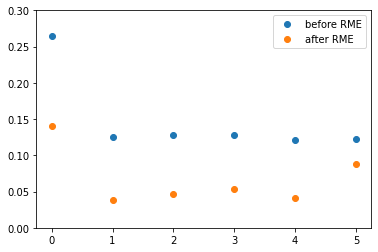

In [ ]:
RME_compare = pd.DataFrame(data={'before RME': RME_before.T.tolist(), 'after RME': RME_after.T.tolist()})
RME_compare.plot(style='o')
plt.ylim([0,0.3])

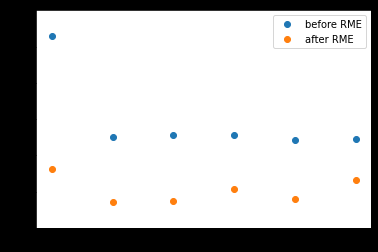

in order to see if thde equation is right, i am gonna take the first measurements, then apply the mitigation - and if it's correct than we should get the exact estimation we wanna see.

In [ ]:
def initialMfirst(i):
  result_table_300000_last_x = result_table[i][:300000].copy()
  simulation_data_input_table_x = simulation_data_input_table[i].copy()
  simulation_data_input_table_x[simulation_data_input_table_x == 1] = -1
  simulation_data_input_table_x[simulation_data_input_table_x == 0] = 1
  result_table_300000_last_x[result_table_300000_last_x == 1] = -1
  result_table_300000_last_x[result_table_300000_last_x == 0] = 1
  return result_table_300000_last_x,simulation_data_input_table_x

In [ ]:
RME_before = np.zeros([6])
RME_before_std = np.zeros([6])
RME = np.zeros([10,1])
average_qbits = np.zeros([10,1])
for i in range(6):
  result_table_300000_last_x,simulation_data_input_table_x = initialMfirst(i)
  for column in result_table_300000_last_x.columns:
    ii=result_table_300000_last_x.columns.get_loc(column)
    average_qbits[ii] = result_table_300000_last_x[column].mean()
    RME[result_table_300000_last_x.columns.get_loc(column)] = np.abs(simulation_data_input_table_x[0][ii]-average_qbits[ii])
  RME_before[i] = np.mean(RME)
  print(simulation_data_input_table_x[0],
  average_qbits, np.mean(RME))

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1] [[-0.94302   ]
 [-0.54485333]
 [-0.904     ]
 [-0.71161333]
 [-0.92215333]
 [-0.95482   ]
 [-0.23930667]
 [-0.74854667]
 [-0.91312667]
 [-0.6682    ]] 0.24503600000000003
[-1 -1 -1 -1  1  1  1  1  1  1] [[-0.93880667]
 [-0.72936667]
 [-0.90297333]
 [-0.63016   ]
 [ 0.93445333]
 [ 0.84284   ]
 [ 0.96956667]
 [ 0.94291333]
 [ 0.98771333]
 [ 0.89175333]] 0.12294533333333332
[-1  1  1  1 -1 -1 -1  1  1  1] [[-0.93078667]
 [ 0.93524667]
 [ 0.84433333]
 [ 0.97029333]
 [-0.70987333]
 [-0.90506   ]
 [-0.61382   ]
 [ 0.94199333]
 [ 0.98753333]
 [ 0.89739333]] 0.12636666666666665
[ 1 -1  1  1 -1  1  1  1 -1 -1] [[ 0.94092667]
 [-0.90712   ]
 [ 0.8422    ]
 [ 0.96606667]
 [-0.75794667]
 [ 0.93930667]
 [ 0.98553333]
 [ 0.88443333]
 [-0.88384   ]
 [-0.67699333]] 0.12156333333333333
[ 1  1 -1  1  1 -1  1 -1  1 -1] [[ 0.94028   ]
 [ 0.85471333]
 [-0.93154   ]
 [ 0.97238667]
 [ 0.94362667]
 [-0.75186   ]
 [ 0.98892   ]
 [-0.90048   ]
 [ 0.88764667]
 [-0.66364667]] 0.116

In [ ]:
RME_after = np.zeros([6])
RME_after_std = np.zeros([6])
average_qbits = np.zeros([10,1])
for i in range(6):
  result_table_300000_last_x,simulation_data_input_table_x = initialMfirst(i)
  for column in result_table_300000_last_x.columns:
    ii=result_table_300000_last_x.columns.get_loc(column)
    #if (column=='q6'):
      #average_qbits[ii] = simulation_data_input_table_x[0][ii]
    #else :
    Z=np.array([[1,0],[0,-1]])
    Sij=np.array([result_table_300000_last_x[column][result_table_300000_last_x[column] == 1 ].count(),result_table_300000_last_x[column][result_table_300000_last_x[column] == -1 ].count()])
    average_qbits[ii] = np.dot(np.array([1,1]),np.dot(Z,np.dot(ten_qubits_reverse[ii],Sij)))/300000
    RME[ii] = np.sqrt((simulation_data_input_table_x[0][result_table_300000_last_x.columns.get_loc(column)]-average_qbits[result_table_300000_last_x.columns.get_loc(column)])**2)
  RME_after[i] = np.mean(RME)
  print(simulation_data_input_table_x[0],
  average_qbits, np.mean(RME))

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1] [[-1.00583769]
 [-0.77321882]
 [-0.99016869]
 [-0.95290798]
 [-1.14449801]
 [-1.09393189]
 [-0.60783705]
 [-0.88599967]
 [-1.10199546]
 [-0.99818875]] 0.11379420793817774
[-1 -1 -1 -1  1  1  1  1  1  1] [[-1.00135116]
 [-1.00280376]
 [-0.98902661]
 [-0.85829028]
 [ 0.99323477]
 [ 0.91055061]
 [ 0.98449215]
 [ 1.02233875]
 [ 1.03761295]
 [ 1.00096258]] 0.03294747858972526
[-1  1  1  1 -1 -1 -1  1  1  1] [[-0.99281114]
 [ 1.06842948]
 [ 0.95470973]
 [ 1.00082604]
 [-0.90007471]
 [-1.03844696]
 [-1.1011464 ]
 [ 1.02130079]
 [ 1.03741034]
 [ 1.0081905 ]] 0.042815491827466245
[ 1 -1  1  1 -1  1  1  1 -1 -1] [[ 1.00026503]
 [-1.22397742]
 [ 0.95233657]
 [ 0.99591627]
 [-0.95542728]
 [ 1.01811586]
 [ 1.00552346]
 [ 0.95636046]
 [-1.06903004]
 [-1.00945781]] 0.04663290265749962
[ 1  1 -1  1  1 -1  1 -1  1 -1] [[ 0.99957643]
 [ 0.96822404]
 [-1.0208047 ]
 [ 1.00325769]
 [ 1.00379713]
 [-0.86762115]
 [ 1.00998438]
 [-1.05741384]
 [ 0.92497671]
 [-0.99235344]] 0.03

(0.0, 0.3)

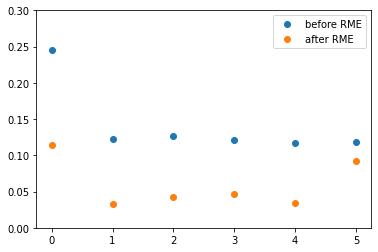

In [ ]:
RME_compare = pd.DataFrame(data={'before RME': RME_before.T.tolist(), 'after RME': RME_after.T.tolist()})
RME_compare.plot(style='o')
plt.ylim([0,0.3])

since i can see that there isn't overfitting - actually it's the same error rate... i shall remove the eigenvalues and see how it'll affect the results

In [ ]:
RME_before = np.zeros([6])
RME_before_std = np.zeros([6])
RME = np.zeros([10,1])
average_qbits = np.zeros([10,1])
for i in range(6):
  result_table_300000_first = result_table[i][:300000]
  for column in result_table_300000_first.columns:
    average_qbits[result_table_300000_first.columns.get_loc(column)] = result_table_300000_first[column].mean()
    RME[result_table_300000_first.columns.get_loc(column)] = np.sqrt((simulation_data_input_table[i][0][result_table_300000_first.columns.get_loc(column)]-average_qbits[result_table_300000_first.columns.get_loc(column)])**2)
  RME_before[i] = np.mean(RME)
  RME_before_std[i] = np.std(RME)
  print(simulation_data_input_table[i][0],
  average_qbits, np.mean(RME))

[1 1 1 1 1 1 1 1 1 1] [[0.97151   ]
 [0.77242667]
 [0.952     ]
 [0.85580667]
 [0.96107667]
 [0.97741   ]
 [0.61965333]
 [0.87427333]
 [0.95656333]
 [0.8341    ]] 0.12251799999999999
[1 1 1 1 0 0 0 0 0 0] [[0.96940333]
 [0.86468333]
 [0.95148667]
 [0.81508   ]
 [0.03277333]
 [0.07858   ]
 [0.01521667]
 [0.02854333]
 [0.00614333]
 [0.05412333]] 0.061472666666666655
[1 0 0 0 1 1 1 0 0 0] [[0.96539333]
 [0.03237667]
 [0.07783333]
 [0.01485333]
 [0.85493667]
 [0.95253   ]
 [0.80691   ]
 [0.02900333]
 [0.00623333]
 [0.05130333]] 0.06318333333333334
[0 1 0 0 1 0 0 0 1 1] [[0.02953667]
 [0.95356   ]
 [0.0789    ]
 [0.01696667]
 [0.87897333]
 [0.03034667]
 [0.00723333]
 [0.05778333]
 [0.94192   ]
 [0.83849667]] 0.060781666666666664
[0 0 1 0 0 1 0 1 0 1] [[0.02986   ]
 [0.07264333]
 [0.96577   ]
 [0.01380667]
 [0.02818667]
 [0.87593   ]
 [0.00554   ]
 [0.95024   ]
 [0.05617667]
 [0.83182333]] 0.058245000000000005
[0 0 0 1 0 0 1 1 1 0] [[0.02958667]
 [0.07460333]
 [0.01569667]
 [0.95734333]
 [0.

In [ ]:
RME_after = np.zeros([6])
RME = np.zeros([10,1])
average_qbits = np.zeros([10,1])
Z=np.array([[0,0],[0,1]])
for i in range(6):
  result_table_300000_first = result_table[i][:300000]
  for column in result_table_300000_last.columns:
    ii = result_table_300000_first.columns.get_loc(column)
    Sij=np.array([result_table_300000_first[column][result_table_300000_first[column] == 0 ].count(),result_table_300000_first[column][result_table_300000_first[column] == 1 ].count()])
    average_qbits[ii] = np.dot(np.array([1,1]),np.dot(Z,np.dot(ten_qubits_reverse[ii],Sij)))/300000
    RME[ii] = np.sqrt((simulation_data_input_table[i][0][ii]-average_qbits[ii])**2)
  RME_after[i] = np.mean(RME)
  print(simulation_data_input_table[i][0],
  average_qbits, np.mean(RME))

[1 1 1 1 1 1 1 1 1 1] [[1.00291885]
 [0.88660941]
 [0.99508435]
 [0.97645399]
 [1.072249  ]
 [1.04696595]
 [0.80391853]
 [0.94299984]
 [1.05099773]
 [0.99909437]] 0.05689710396908885
[1 1 1 1 0 0 0 0 0 0] [[ 1.00067558e+00]
 [ 1.00140188e+00]
 [ 9.94513305e-01]
 [ 9.29145139e-01]
 [ 3.38261408e-03]
 [ 4.47246939e-02]
 [ 7.75392343e-03]
 [-1.11693746e-02]
 [-1.88064760e-02]
 [-4.81291570e-04]] 0.016473739294862594
[1 0 0 0 1 1 1 0 0 0] [[ 9.96405572e-01]
 [-3.42147394e-02]
 [ 2.26451335e-02]
 [-4.13019937e-04]
 [ 9.50037357e-01]
 [ 1.01922348e+00]
 [ 1.05057320e+00]
 [-1.06503936e-02]
 [-1.87051709e-02]
 [-4.09525016e-03]] 0.021407745913733105
[0 1 0 0 1 0 0 0 1 1] [[-1.32513485e-04]
 [ 1.11198871e+00]
 [ 2.38317133e-02]
 [ 2.04186731e-03]
 [ 9.77713639e-01]
 [-9.05793061e-03]
 [-2.76173150e-03]
 [ 2.18197682e-02]
 [ 1.03451502e+00]
 [ 1.00472890e+00]] 0.023316451328749856
[0 0 1 0 0 1 0 1 0 1] [[ 2.11784945e-04]
 [ 1.58879823e-02]
 [ 1.01040235e+00]
 [-1.62884738e-03]
 [-1.89856252e-03

(0.0, 0.3)

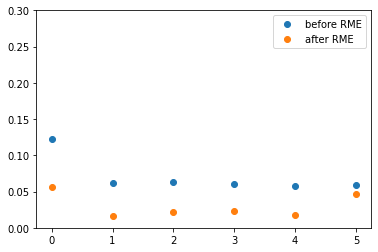

In [ ]:
RME_compare = pd.DataFrame(data={'before RME': RME_before.T.tolist(), 'after RME': RME_after.T.tolist()})
RME_compare.plot(style='o')
plt.ylim([0,0.3])

i don't have the over-fitting... weird.
\
here i'm trying to mitigate the original measurements with the last measurements...

In [ ]:
RME_before = np.zeros([6])
RME_before_std = np.zeros([6])
RME = np.zeros([10,1])
average_qbits = np.zeros([10,1])
for i in range(6):
  result_table_300000_first = result_table[i][300000:]
  for column in result_table_300000_first.columns:
    average_qbits[result_table_300000_first.columns.get_loc(column)] = result_table_300000_first[column].mean()
    RME[result_table_300000_first.columns.get_loc(column)] = np.sqrt((simulation_data_input_table[i][0][result_table_300000_first.columns.get_loc(column)]-average_qbits[result_table_300000_first.columns.get_loc(column)])**2)
  RME_before[i] = np.mean(RME)
  RME_before_std[i] = np.std(RME)
  print(simulation_data_input_table[i][0],
  average_qbits, np.mean(RME))

[1 1 1 1 1 1 1 1 1 1] [[0.97136]
 [0.75888]
 [0.95234]
 [0.84628]
 [0.96098]
 [0.97658]
 [0.54298]
 [0.87246]
 [0.9569 ]
 [0.83712]] 0.13241199999999997
[1 1 1 1 0 0 0 0 0 0] [[0.96796]
 [0.8483 ]
 [0.95052]
 [0.81894]
 [0.03314]
 [0.08178]
 [0.01522]
 [0.02864]
 [0.00584]
 [0.04958]] 0.06284799999999999
[1 0 0 0 1 1 1 0 0 0] [[0.96226]
 [0.03218]
 [0.07914]
 [0.01442]
 [0.84472]
 [0.95262]
 [0.80954]
 [0.02898]
 [0.0058 ]
 [0.05056]] 0.064194
[0 1 0 0 1 0 0 0 1 1] [[0.032  ]
 [0.96112]
 [0.08264]
 [0.01748]
 [0.85358]
 [0.03002]
 [0.00772]
 [0.0567 ]
 [0.9395 ]
 [0.83488]] 0.063748
[0 0 1 0 0 1 0 1 0 1] [[0.0323 ]
 [0.07208]
 [0.96606]
 [0.01266]
 [0.02708]
 [0.85368]
 [0.00528]
 [0.9511 ]
 [0.05544]
 [0.82898]] 0.060501999999999986
[0 0 0 1 0 0 1 1 1 0] [[0.03208]
 [0.07588]
 [0.01512]
 [0.96576]
 [0.02774]
 [0.00648]
 [0.85366]
 [0.95038]
 [0.8323 ]
 [0.05568]] 0.061087999999999996


In [ ]:
RME_after = np.zeros([6])
RME = np.zeros([10,1])
average_qbits = np.zeros([10,1])
Z=np.array([[0,0],[0,1]])
for i in range(6):
  result_table_300000_last = result_table[i][300000:]
  for column in result_table_300000_last.columns:
    ii = result_table_300000_last.columns.get_loc(column)
    Sij=np.array([result_table_300000_last[column][result_table_300000_last[column] == 0 ].count(),result_table_300000_last[column][result_table_300000_last[column] == 1 ].count()])
    average_qbits[ii] = np.dot(np.array([1,1]),np.dot(Z,np.dot(ten_qubits_reverse[ii],Sij)))/300000
    RME[ii] = np.sqrt((simulation_data_input_table[i][0][ii]-average_qbits[ii])**2)
  RME_after[i] = np.mean(RME)
  print(simulation_data_input_table[i][0],
  average_qbits, np.mean(RME))

[1 1 1 1 1 1 1 1 1 1] [[1.00275912]
 [0.86975366]
 [0.99546257]
 [0.96538764]
 [1.0721377 ]
 [1.04604045]
 [0.70292433]
 [0.940954  ]
 [1.05137669]
 [1.00296464]] 0.07007964031902134
[1 1 1 1 0 0 0 0 0 0] [[ 0.99913866]
 [ 0.98101654]
 [ 0.99343797]
 [ 0.93362899]
 [ 0.0038048 ]
 [ 0.04829286]
 [ 0.00775831]
 [-0.01106031]
 [-0.01914791]
 [-0.00630378]] 0.01891458186931843
[1 0 0 0 1 1 1 0 0 0] [[ 9.93069071e-01]
 [-3.44594464e-02]
 [ 2.40986938e-02]
 [-9.16387986e-04]
 [ 9.38273690e-01]
 [ 1.01932383e+00]
 [ 1.05403744e+00]
 [-1.06767187e-02]
 [-1.91929362e-02]
 [-5.04786573e-03]] 0.023641056123705383
[0 1 0 0 1 0 0 0 1 1] [[ 0.00249054]
 [ 1.12139541]
 [ 0.02799216]
 [ 0.00263816]
 [ 0.94847526]
 [-0.00942218]
 [-0.00212069]
 [ 0.02059753]
 [ 1.03179104]
 [ 1.00009398]] 0.02700664336229424
[0 0 1 0 0 1 0 1 0 1] [[ 0.00281   ]
 [ 0.01518704]
 [ 1.01072495]
 [-0.00296084]
 [-0.0031728 ]
 [ 0.90900069]
 [-0.00533466]
 [ 1.02967719]
 [ 0.03668245]
 [ 0.99253286]] 0.020501637427904753
[0 

(0.0, 0.3)

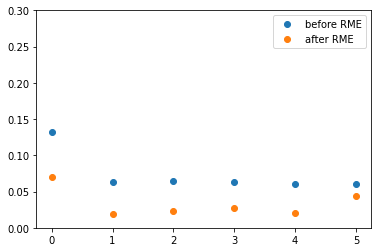

In [ ]:
RME_compare = pd.DataFrame(data={'before RME': RME_before.T.tolist(), 'after RME': RME_after.T.tolist()})
RME_compare.plot(style='o')
plt.ylim([0,0.3])